# 06. 사후분포근사

<br>

#### 사전분포 매개변수 $\theta$의 범위에 대해서 $(\theta_1 \sim \theta_k)$, 

$$f(\theta | y) = \frac{f(\theta)L(\theta | y)}{f(y)} \propto f(\theta)L(\theta | y)  .$$

#### 정규화 상수 $f(y)$는

$$f(y) = \int_{\theta_1}\int_{\theta_2} \cdots \int_{\theta_k} f(\theta)L(\theta | y) d\theta_k \cdots d\theta_2 d\theta_1  .$$

<br>

### 복잡한 구조의 '사전분포 $\rightarrow$ 관측값의 분포 $\rightarrow$ 사후분포'의 구조에서는, 사후분포를 계산하는 것이 아니라, $\theta$의 범위 내에서 시뮬레이션을 통하여 근사시킴

$$\left\lbrace \theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(N)} \right\rbrace  ,$$

In [2]:
library(tidyverse)
library(janitor)
library(rstan)
library(bayesplot)

<br>

## 06.01. 그리드 근사
> 이산 근사된 사후분포의 확률밀도함수 $f(\theta|y)$로부터, $N$개의 독립적인 $\theta$ 표본값 $\left\lbrace \theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(N)} \right\rbrace$을 추출
>

<br>

#### 그리드 근사 절차
1. $\theta$의 가능한 범위 정의
2. 각 $\theta$값 별 사전확률밀도함수값 $f(\theta)$와 가능도 $L(\theta|y)$를 계산
3. (a) 각 $\theta$값 별 사전확률밀도함수값 X 가능도의 곱 $f(\theta)L(\theta|y)$계산과,

    (b) 모든 $\theta$값에 대해서 정규화 (모든 값의 합이 1이 되게)를 통하여,
    
    각 $\theta$값 별 사후 확률밀도함수$f(\theta |y)$값을 얻음
    
4. 각 $\theta$별 정규화된 사후 확률밀도함수값을 각 $\theta$별 확률값으로 가지는 $N$번의 샘플링 진행

<br>

#### 그리드 근사는 가능한 모든 $\theta$값에 대해서 고려할 필요가 없으며, 유한하고 계산가능한 $\theta$값을 통하여 사후확률 밀도함수를 근사화 하는 것

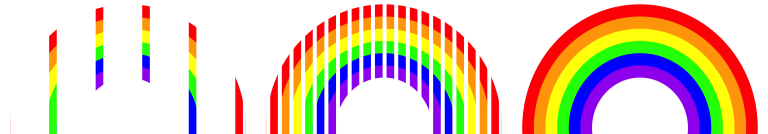

<br>

### 베타-이항분포 예시

- $N=10$인 이항분포의 $\pi$에 대한 사전분포가 $Beta(2, 2)$를 따를때,

$$\begin{equation} 
\begin{split}
Y|\pi & \sim \text{Bin}(10, \pi) \\
\pi   & \sim \text{Beta}(2, 2)  . \\
\end{split}
\end{equation}$$

- $Y=9$의 성공을 관측했다면, 켤레사전분포에 따라, 사후분포는 $\alpha= Y + \alpha = 9 + 2$, $\beta = n - Y + \beta = 10 - 9 + 2$를 매개변수로 가지는 베타분포를 따름
    



$$\pi | (Y = 9) \sim \text{Beta}(11, 3)  .$$

<br>

* 만약 $\pi$에 대한 사전분포를 고려하지 않고, 

    $\pi$값이 $\pi \in \{0, 0.2, 0.4, 0.6, 0.8, 1\}$의 범위를 가진다면,
    
    

In [19]:
grid_data <- data.frame(pi_grid = seq(from = 0, to = 1, length = 6))

- 각 $\pi$값 별 사전 확률밀도함수값과, 관측값이 $Y=9$일 가능도 계산

In [20]:
grid_data <- grid_data %>% 
  mutate(prior = dbeta(pi_grid, 2, 2),
         likelihood = dbinom(9, 10, pi_grid))
grid_data

pi_grid,prior,likelihood
<dbl>,<dbl>,<dbl>
0.0,0.00,0.000000000
0.2,0.96,0.000004096
0.4,1.44,0.001572864
0.6,1.44,0.040310784
0.8,0.96,0.268435456
1.0,0.00,0.000000000


- 사전 확률밀도함수값과 가능도의 곱 (= 비정규 사후 확률밀도함수값)을 계산 후, 정규화 (값의 합이 1이되게)

In [27]:
grid_data <- grid_data %>% 
  mutate(unnormalized = likelihood * prior,
         posterior = unnormalized / sum(unnormalized))

round(grid_data, 2)
grid_data %>% 
  summarize(sum(unnormalized), sum(posterior))

pi_grid,prior,likelihood,unnormalized,posterior
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0,0.00,0.00,0.00,0.00
0.2,0.96,0.00,0.00,0.00
0.4,1.44,0.00,0.00,0.01
0.6,1.44,0.04,0.06,0.18
0.8,0.96,0.27,0.26,0.81
1.0,0.00,0.00,0.00,0.00


sum(unnormalized),sum(posterior)
<dbl>,<dbl>
0.3180144,1


- 각 $\pi$값 별 사후 확률밀도함수값 확인

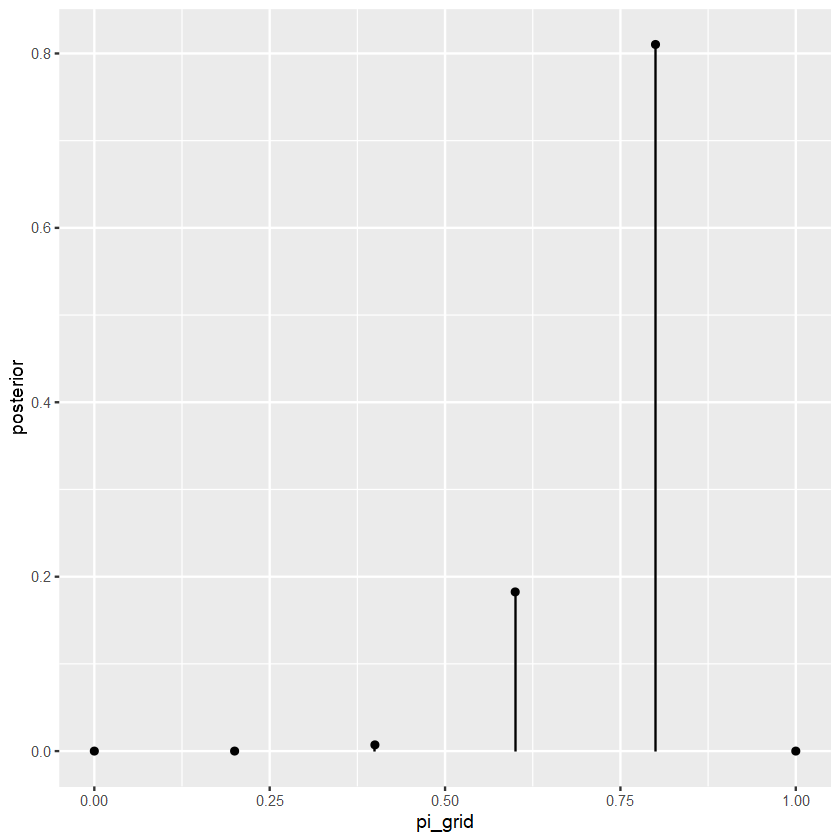

In [22]:
ggplot(grid_data, aes(x = pi_grid, y = posterior)) + 
  geom_point() + 
  geom_segment(aes(x = pi_grid, xend = pi_grid, y = 0, yend = posterior))

- 사후 확률밀도함수값을 각 $\pi$별 등장 확률값으로 가지는 10000번의 샘플링

In [23]:
set.seed(84735)

post_sample <- sample_n(grid_data, size = 10000, 
                        weight = posterior, replace = TRUE)

In [25]:
post_sample %>% head

,pi_grid,prior,likelihood,unnormalized,posterior
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8,0.96,0.26843546,0.25769804,0.8103344
2,0.8,0.96,0.26843546,0.25769804,0.8103344
3,0.8,0.96,0.26843546,0.25769804,0.8103344
4,0.6,1.44,0.04031078,0.05804753,0.1825311
5,0.8,0.96,0.26843546,0.25769804,0.8103344
6,0.8,0.96,0.26843546,0.25769804,0.8103344


- 10000번의 샘플링 결과의 히스토그램

In [26]:
post_sample %>% 
  tabyl(pi_grid) %>% 
  adorn_totals("row")

,pi_grid,n,percent
,<chr>,<int>,<dbl>
1,0.4,69,0.0069
2,0.6,1885,0.1885
3,0.8,8046,0.8046
4,Total,10000,1.0000


- 그리드 근사를 통하여 도출된 사후분포가, 이론적 사후분포 $Beta(11, 3)$과 유사함을 확인

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


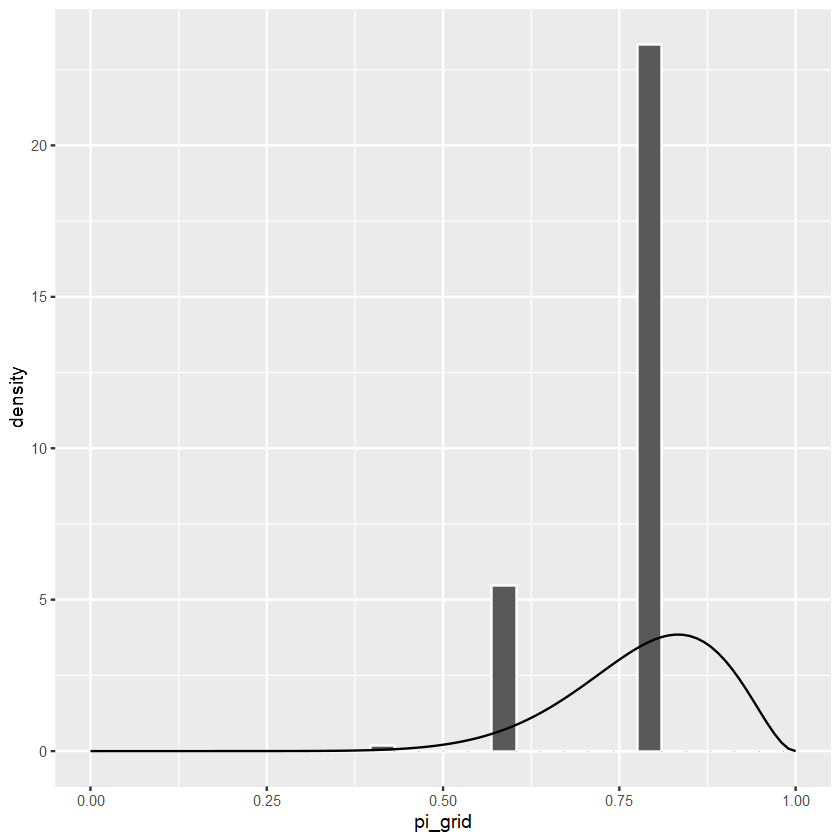

In [29]:
ggplot(post_sample, aes(x = pi_grid)) + 
  geom_histogram(aes(y = ..density..), color = "white") + 
  stat_function(fun = dbeta, args = list(11, 3)) + 
  lims(x = c(0, 1))

<br>

#### $\pi$값의 범위를 더 밀도있게 설정할 경우 ($\pi \in \{0, 0.01, 0.02, \ldots, 0.99, 1\}$)

In [30]:
grid_data  <- data.frame(pi_grid = seq(from = 0, to = 1, length = 101))

grid_data <- grid_data %>% 
  mutate(prior = dbeta(pi_grid, 2, 2),
         likelihood = dbinom(9, 10, pi_grid))

grid_data <- grid_data %>% 
  mutate(unnormalized = likelihood * prior,
         posterior = unnormalized / sum(unnormalized))

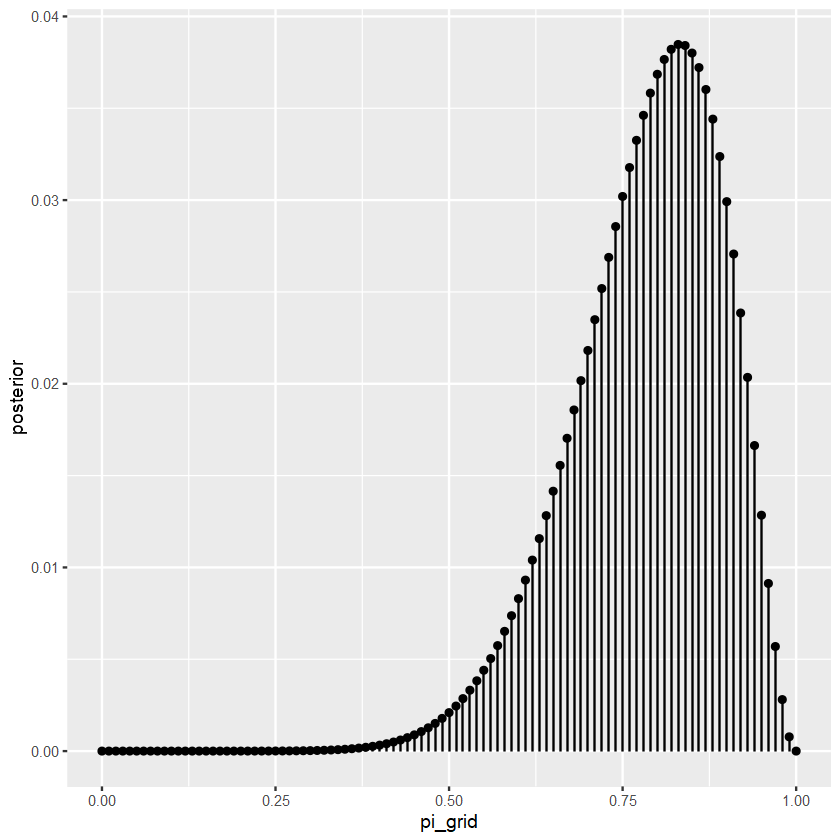

In [31]:
ggplot(grid_data, aes(x = pi_grid, y = posterior)) + 
  geom_point() + 
  geom_segment(aes(x = pi_grid, xend = pi_grid, y = 0, yend = posterior))

In [32]:
set.seed(84735)
post_sample <- sample_n(grid_data, size = 10000, 
                        weight = posterior, replace = TRUE)

Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


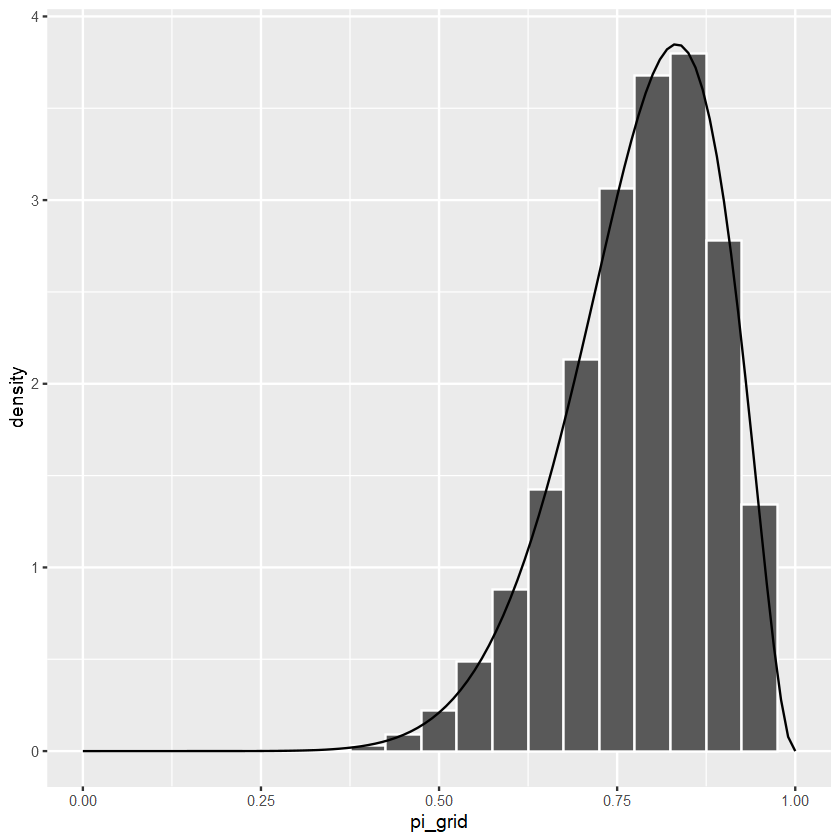

In [33]:
ggplot(post_sample, aes(x = pi_grid)) + 
  geom_histogram(aes(y = ..density..), color = "white", binwidth = 0.05) + 
  stat_function(fun = dbeta, args = list(11, 3)) + 
  lims(x = c(0, 1))

<br>

### 감마-포아송 예시
- 각 $Y_i$가 $\lambda$를 매개변수로 가지는 포아송 분포를 (하나의 기간에 평균적으로 $\lambda$의 사건 관측) 따르고,
    
    $\lambda$의 사전분포가 $Gamma(3, 1)$를 따를떄

$$\begin{equation} 
\begin{split}
Y_i|\lambda & \stackrel{ind}{\sim} \text{Pois}(\lambda) \\
\lambda   & \sim \text{Gamma}(3, 1)  . \\
\end{split}
\end{equation}$$

- $Y_1=2$이고 $Y_2=8$이라면, 켤레사전분포에 의하여 사후분포는 $Gamma(3+10, 1+2)$

$$\lambda | ((Y_1,Y_2) = (2,8)) \sim \text{Gamma}(13, 3)  .$$

In [53]:
library(bayesrules)

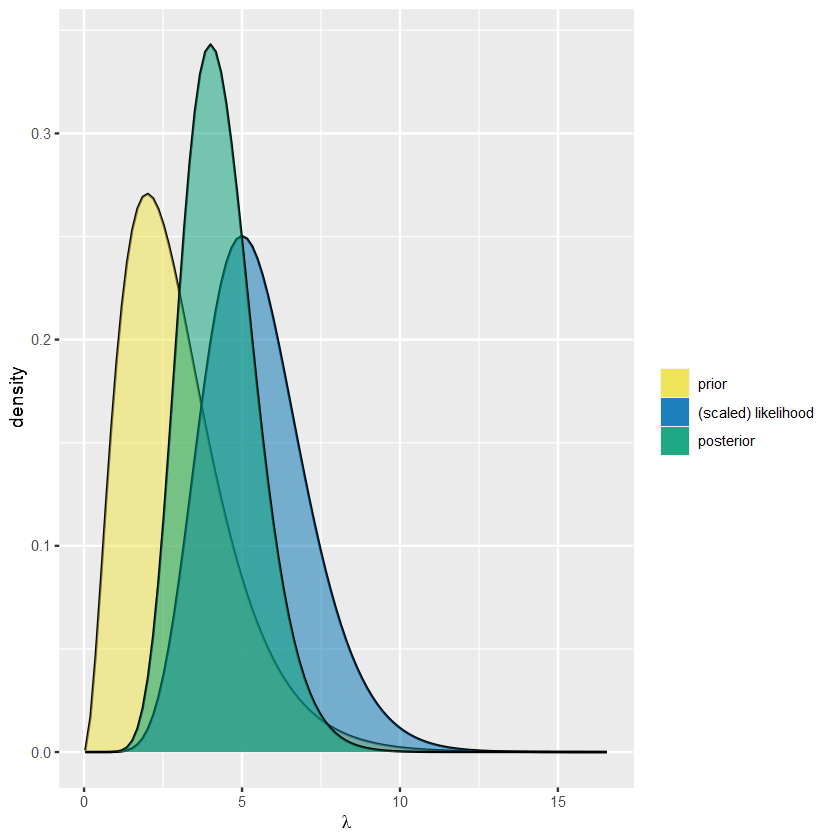

In [55]:
plot_gamma_poisson(s = 3, r = 1, sum_y = 10, n = 2, posterior = T)

<br>

- 만약 $\lambda$의 사전분포를 고려하지 않고

    $\lambda$가 $\lambda \in [0,15)$ 범위를 가진다면

<br>

1. 501개의 $\lambda$ 값으로 구성된 그리드 정의

In [56]:
grid_data   <- data.frame(lambda_grid = seq(from = 0, to = 15, length = 501))

2. 각 $\lambda$값에서 사전 확률밀도함수값 및 가능도 계산

In [57]:
grid_data <- grid_data %>% 
  mutate(prior = dgamma(lambda_grid, 3, 1),
         likelihood = dpois(2, lambda_grid) * dpois(8, lambda_grid))

3. 사후 확률밀도함수값 계산 및 정규화

In [58]:
grid_data <- grid_data %>% 
  mutate(unnormalized = likelihood * prior,
         posterior = unnormalized / sum(unnormalized))

4. 사후 확률밀도함수값을 이용한 샘플링

In [59]:
set.seed(84735)

post_sample <- sample_n(grid_data, size = 10000, 
                        weight = posterior, replace = TRUE)

5. 샘플링을 활용한 사후 확률밀도함수 추정

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


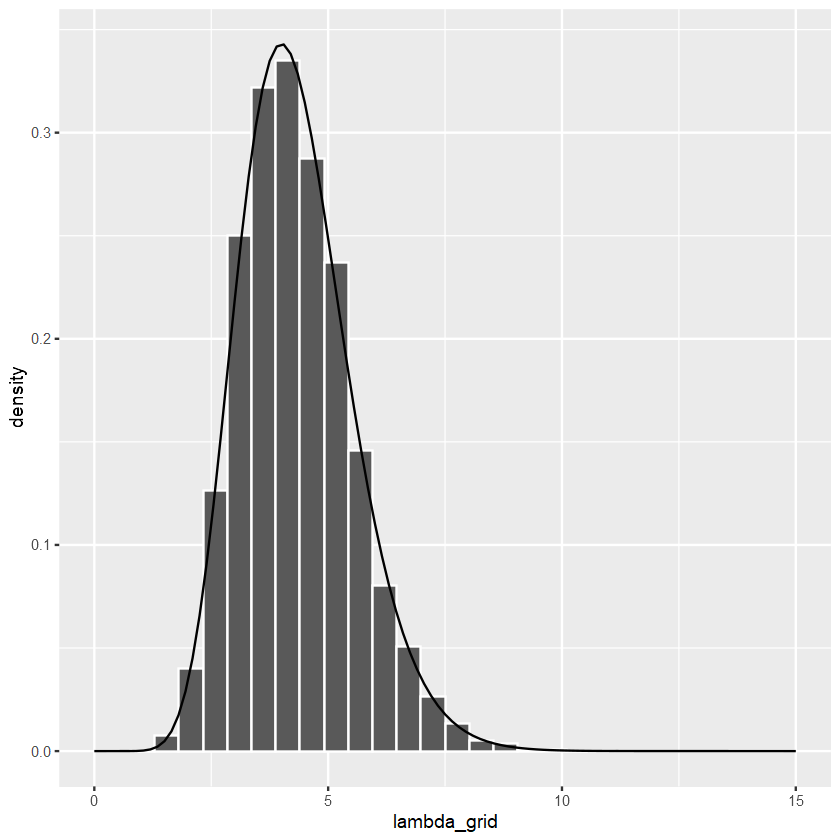

In [61]:
ggplot(post_sample, aes(x = lambda_grid)) + 
  geom_histogram(aes(y = ..density..), color = "white") + 
  stat_function(fun = dgamma, args = list(13, 3)) + 
  lims(x = c(0, 15))

<br>

### 그리드 근사의 한계
- 그리드의 밀도 (크기 & 차원)가 높아질수록, 더 정교한 사후분포추정이 가능하지만 연산량이 증가 $\rightarrow$ 차원의 저주

<br>

## 06.02. 마르코프 체인 (Markov Chain)

<br>

### 마르코프 체인
- 마르코프 체인의 어원 : 러시아 수학자 Andrey Markov (1856–1922)의 이름 
- 몬테 카를로의 어원:
    - 1940년대 그들의 극비 핵무기 프로젝트의 일환으로, 스타니슬라프 울람(Stanislav Ulam), 존 폰 노이만(John von Neumann), 그리고 로스 앨라모스 국립 연구소의 협력자들은 중성자 여행을 시뮬레이션하고 더 잘 이해하기 위해 마코프 체인들을 사용 (Eckhardt 1987). 
    - 로스 앨라모스 팀은 작업을 암호명 "몬테 카를로(Monte Carlo)"로 불렀는데, 이것은  French Riviera에 있는 몬테카를로 카지노에서 영감을 받음

<br>


- **오늘날 "마르코프 체인 몬테카를로"는 몬테카를로 프로젝트가 개척한 방법을 사용하여 확률 모델을 시뮬레이션하기 위해 마르코프 체인을 적용하는 것을 의미**
- 그리드 근사와 달리 MCMC 시뮬레이션 방법은 더 복잡한 베이지안 모델에 대해 확장가능

    **그러나 그리드 근사와 마찬가지로 사후분포의 pdf $f(\theta|y)$에서 직접 추출되지 않음**
    
- 또한, 그리드 근사 샘플과 달리 MCMC 샘플은 상호 독립적이지 않음

    - **각 샘플 값은 이전 값에 직접적으로 의존 $\rightarrow$ Chain(=사슬) 특성을 보유**
    
        $\left\lbrace \theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(N)} \right\rbrace$가 $N$크기의 MCMC 샘플이라고 할 떄,
        
        $(i+1)$번째 체인 값 $\theta^({i+1})$은. 데이터 $y$와 $i$번째 체인 값 $\theta^({i})$에 조건부 확률밀도함수 형태로 의존
        
        $$f\left(\theta^{(i + 1)} \; | \; \theta^{(i)}, y\right)  .$$
        
        <br>
        
        이러한 **마로코프 속성**은
        
        $$f\left(\theta^{(i + 1)} \; | \; \theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(i)}, y\right) = f\left(\theta^{(i + 1)} \; | \; \theta^{(i)}, y\right)  .$$로 정의
        
        <br>
        
        **또한, 마르코프 체인에 의한 샘플링의 확률밀도함수 Pdf는, 사후분포의 Pdf와 동일하지 않음**
        
        $$f\left(\theta^{(i + 1)} \; | \; \theta^{(i)}, y\right) \ne f\left(\theta^{(i + 1)} \; | \; y\right)  .$$

#### $\rightarrow$ MCMC는 $N$개의 상호의존적인 $\theta$값의 체인 (Chain)을 생성하며, 사후분포 확률밀도함수 $f(\theta|y)$의 값이 아님

<br>

### 베타-이항분포 예시

1. **모델 정의**
- `data` : 관측값 $Y$의 분포에 대한 범위 지정 
- `parameters` : 사전분포 매개변수 $\pi$의 가능한 범위 (그리드)정의
- `model` : 관측값의 분포 & 사전분포 정의

In [68]:
bb_model <- "
  data {
    int<lower = 0, upper = 10> Y;
  }
  parameters {
    real<lower = 0, upper = 1> pi;
  }
  model {
    Y ~ binomial(10, pi);
    pi ~ beta(2, 2);
  }
"

2. **시뮬레이션**

#### `stan(model_code, data, chains, iter, seed, verbose, ...)`
- `model_code` : 1.에서 정의된 모델
- `data` : 관측값 list
- `chains` : 병렬적으로 계산할 마르코프 체인의 수 (샘플의 수) 정의
- `iter` : 각 마르코프 체인의 길이

    - **각 마르코프 체인의 초반 50% 샘플 값들은 'burn-in' 혹은 'warm-up'의 단계로 사용되며, 후반 50% 샘플값들이 최종값들로 유지**
    
    - **burn-in (warm-up)**
    
        - '팬케이크나 크레페를 한 번 만들어본 적이 있다면, 첫 번째 팬케이크가 항상 최악이라는 것을 알 것입니다. 팬의 온도가 완벽하지 않고, 반죽을 얼마나 많이 사용해야 하는지 아직 파악하지 못했으며, 뒤집기 기술을 연습할 시간이 더 필요합니다. MCMC 체인도 비슷합니다.'
        
        <br>
        
        - **마르코프 체인은 시뮬레이션을 시도하는 사후분포에 대한 직접적인 지식이 없다면, 매개변수의 값을 무리하게 샘플링할 수 있음.** 
        
            **하지만 샘플링이 반복되며 체인의 후반에는 이전의 값들을 학습**
            
            **따라서, 각 체인의 초반값들을, 샘플링 결과에 포함하는 것은 좋지 않은 사후분포 근사치를 유발할 수 있으며, "burn-in"은 마르코프 체인 값의 초반 부분을 버리는 행위입니다.**
        
    

<br>

- 각각 10,000번의 반복을 (샘플링) 실행되는 4개의 병렬 마르코프 체인
    - 4개 체인 모두의 처음 5,000번의 반복을 처리한 후,
    
        크기가 5,000인 4개의 마르코프 체인 샘플, 또는 크기 20,000의 결합된 Markov 체인 샘플을 도출

In [ ]:
bb_sim <- stan(model_code = bb_model, data = list(Y = 9), verbose = -1,
               chains = 4, iter = 5000*2, seed = 84735)

In [75]:
bb_sim

Inference for Stan model: anon_model.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

      mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
pi    0.78    0.00 0.11  0.55  0.72  0.80  0.87  0.95  6879    1
lp__ -7.81    0.01 0.74 -9.88 -7.99 -7.52 -7.33 -7.27  6764    1

Samples were drawn using NUTS(diag_e) at Thu Nov 23 22:43:10 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

<br>

- **마르코프 체인은 사후분포에 대한 랜덤 샘플값이 아니며, 각 체인은 서로 독립적이기에,**

     **$\pi$값에 대한 5000 크기의 4개 마르코프 체인 $\left(\pi^{(1)}, \pi^{(2)}, \ldots, \pi^{(5000)} \right)$을 병렬적으로 생성하며,**
     
     **각 체인별 $\pi^{(i)}$값들의 변동 확인 가능**

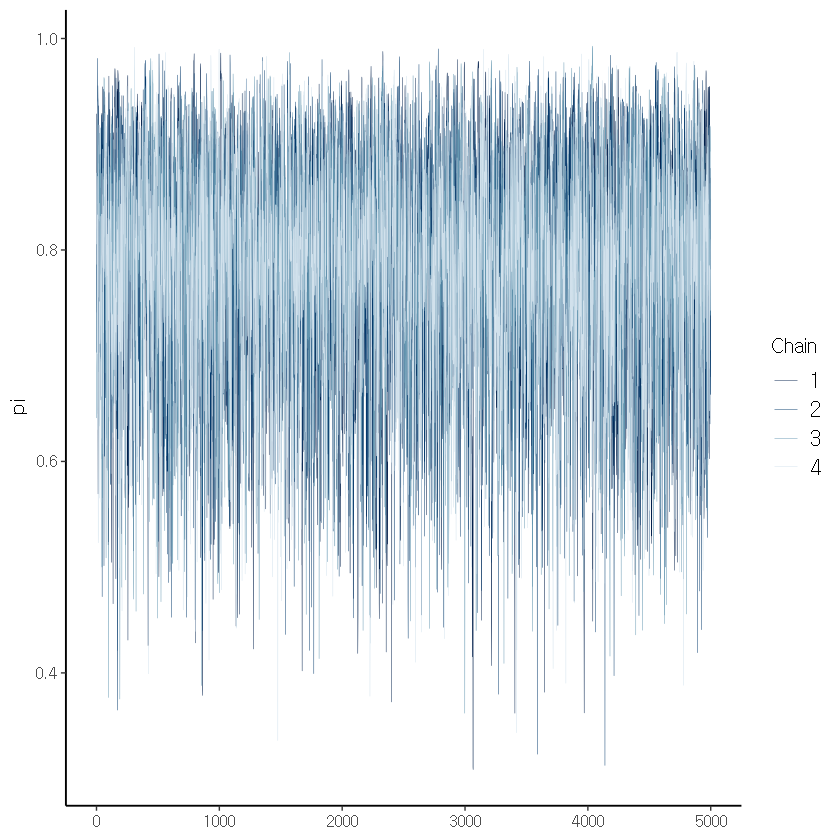

In [118]:
mcmc_trace(bb_sim, pars = "pi", size = 0.1)

- **4개의 개별 체인에서 각각 5,000개씩 결합된 20,000개의 체인값에 히스토그램과 밀도**
    
    **마르코프 체인 값의 분포는 이론적 사후분포 $Beta(11, 3)$와 유사**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


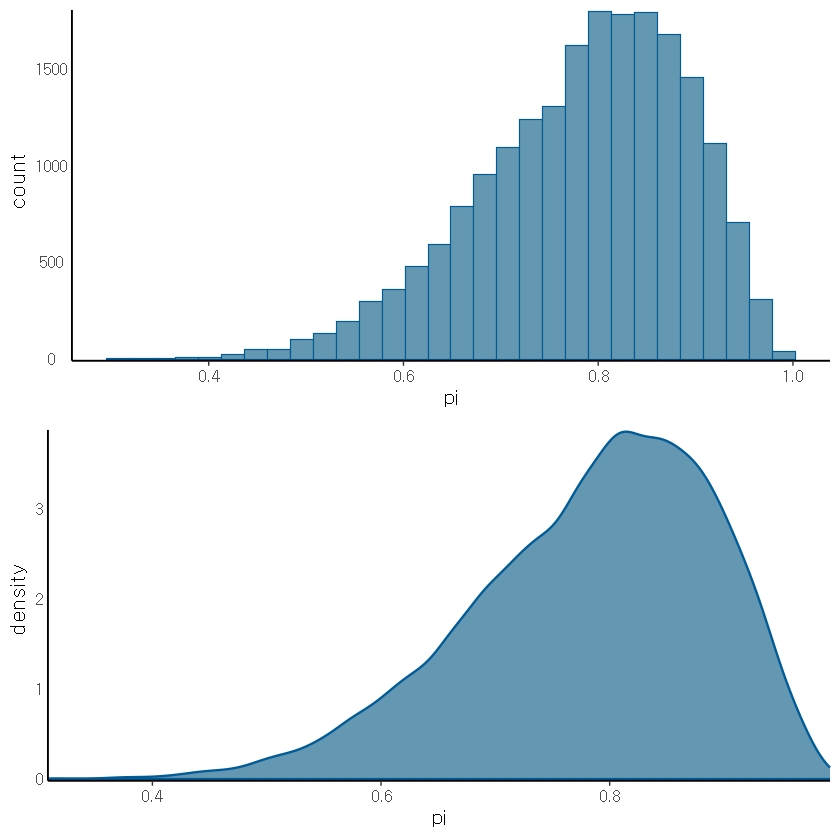

In [124]:
mcmc_hist(bb_sim, pars = "pi") + 
  yaxis_text(TRUE) + 
  ylab("count") -> p1

mcmc_dens(bb_sim, pars = "pi") + 
  yaxis_text(TRUE) + 
  ylab("density") -> p2

gridExtra::grid.arrange(p1, p2)

<br>

### 감마-포아송 예시

In [130]:
gp_model <- "
  data {
    int<lower = 0> Y[2];
  }
  parameters {
    real<lower = 0> lambda;
  }
  model {
    Y ~ poisson(lambda);
    lambda ~ gamma(3, 1);
  }
"

In [ ]:
gp_sim <- stan(model_code = gp_model, data = list(Y = c(2,8)), verbose = -1,
               chains = 4, iter = 5000*2, seed = 84735)

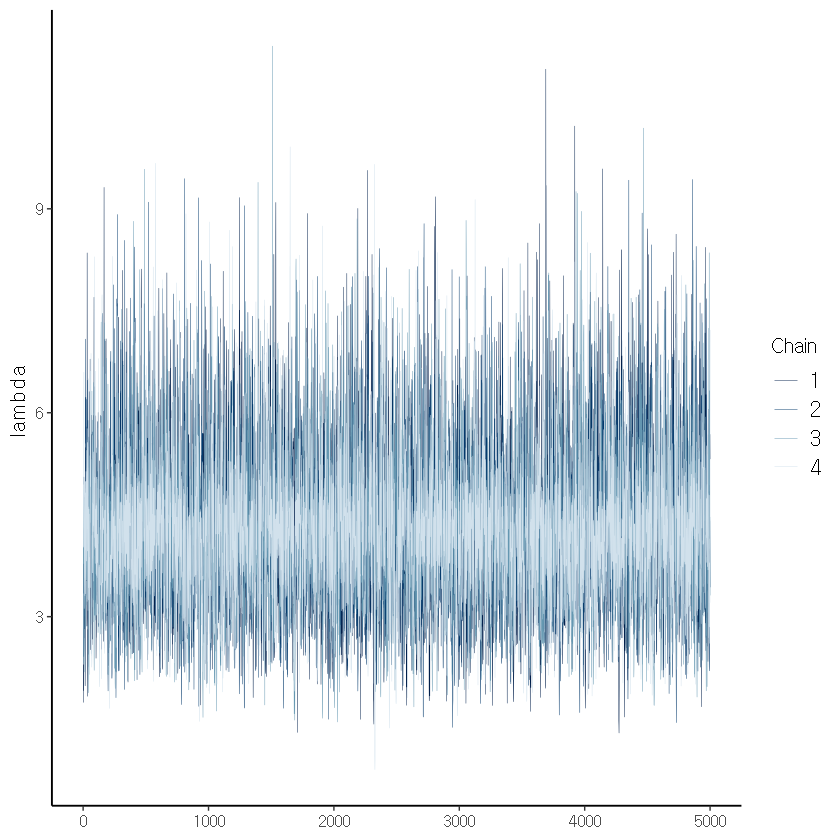

In [132]:
mcmc_trace(gp_sim, pars = "lambda", size = 0.1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


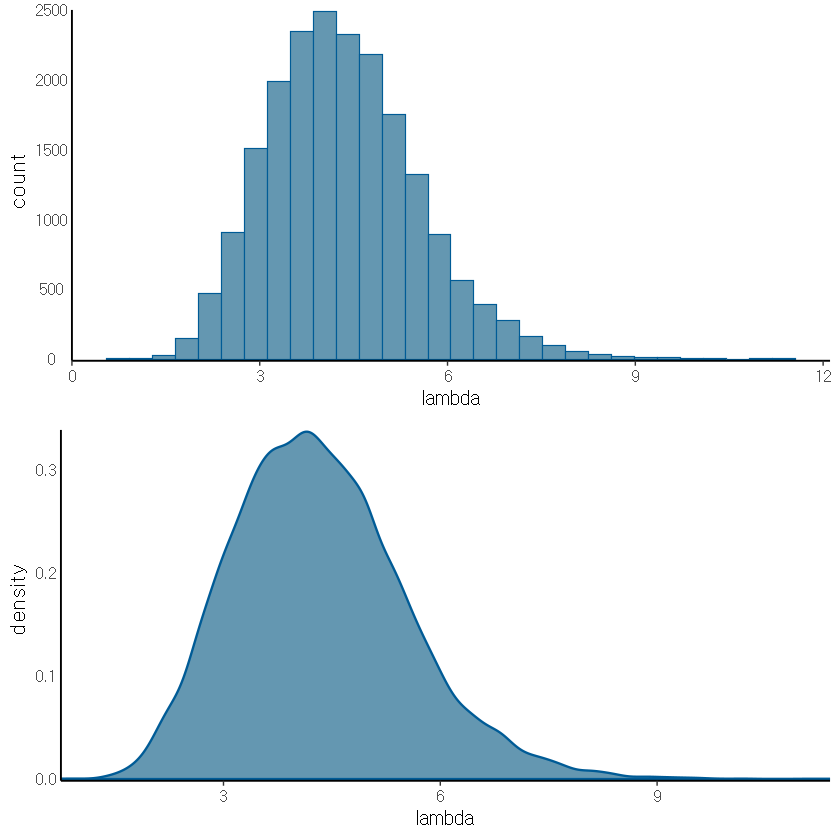

In [134]:
mcmc_hist(gp_sim, pars = "lambda") + 
  yaxis_text(TRUE) + 
  ylab("count") -> p1

mcmc_dens(gp_sim, pars = "lambda") + 
  yaxis_text(TRUE) + 
  ylab("density") -> p2

gridExtra::grid.arrange(p1, p2)

<br>

## 06.03. 마르코프 체인 결과 진단
- 사후분포를 도출할 수 없을 때, 시뮬레이션된 샘플을 통하여 사후분포의 근사치를 얻을 수 있음
- 시뮬레이션은 완벽하지는 않지만, '근사'와 '수렴'을 통하여, 사후분포를 모방하는 분포를 생성

<br>

#### 아래의 기준을 통하여 마르코프 체인 결과를 진단
1. **좋은 마르코프 체인은?**
2. **마르코프 체인 샘플이 사후에 대한 합리적인 근사치를 생성하는지 어떻게 판단하는가?**
3. **각 마르코프 체인 샘플 크기는 얼마나 커야 하는가?**

<br>

### (1) 마르코프 체인 형태 진단
#### 마르코프 체인의 경로가 백색잡음일수록 좋은 모델
- 체인 A의 하향 추세는 5,000번의 반복 후에도 아직 안정화되지 않음

    즉, 아직 타당한 사후분포의 범위를 탐색하지 못함
    
- **하향 추세는 체인의 각 값 사이의 강한 상관 관계를 암시 $\rightarrow$ 체인 값 별 상호 의존성 만족**

    - **하지만, 체인의 경로가 백색잡음일수록 사후분포에 근사치의 오차가 더 작음**

<br>

- 체인 B는 일정 구간에서 변동이 발견되지 않음

<br>

#### 위의 2가지 체인 모두 이론적 사후분포 $Beta(11,3)$와의 근사치가 제대로 생성되지 않음
- 체인 A는 $\pi$의 너무 좁은 범위에 대해서만 샘플링됨
- 체인 B는 $\pi$의 특정 구간에 대해서만 과도하게 샘플링됨
    
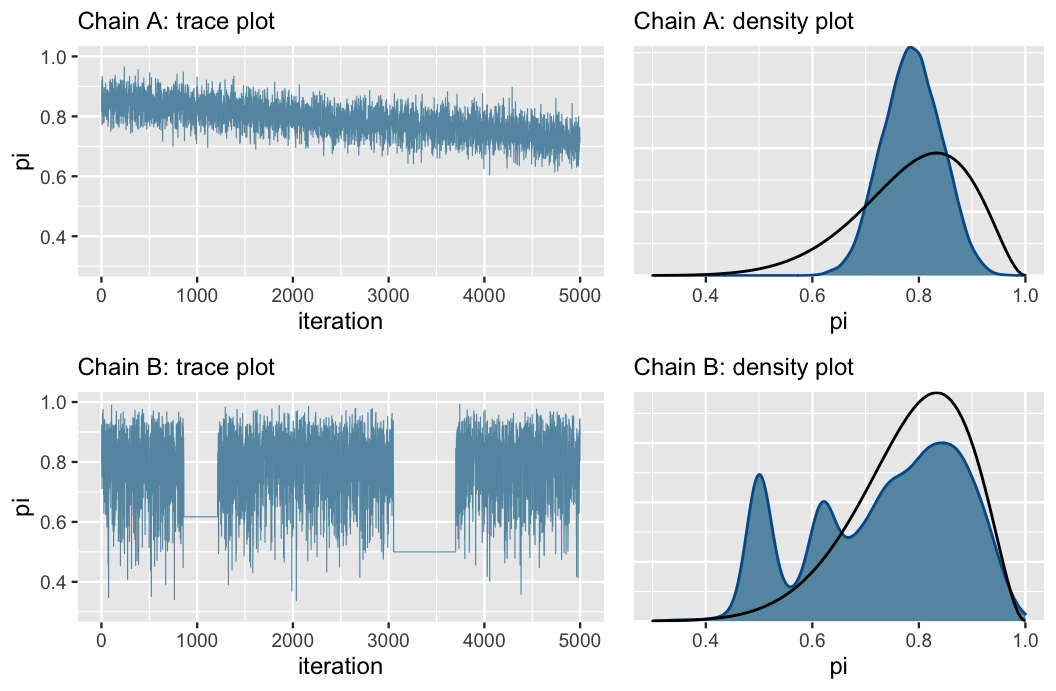

#### 실제 분석에서는 이론적 사후분포를 확인할 수 있는 경우가 거의 없기에, 마르코프 체인의 형태를 진단하는 것이 매우 중요
- 이러한 문제를 방지하기 위하여
1. 가정된 사전분포와, 관측값의 분포가 적절한지 평가
2. 마르코프 체인의 길이 증가

<br>

### (2) 마르코프 체인간의 비교
- 위의 예제에서 생성된 4개의 병렬 마르코프 체인에 대한 경로는 유사하게 나타남. 

    또한, 이 4개의 체인이 거의 구별할 수 없을 정도로 유사한 사후분포 근사치를 생성
    
    **$\rightarrow$ 시뮬레이션이 안정적이고, 체인의 길이가 충분히 길다는 증거**
    
    **$\rightarrow$체인의 길이를 더 늘려도 더이상 개선되지 않음**

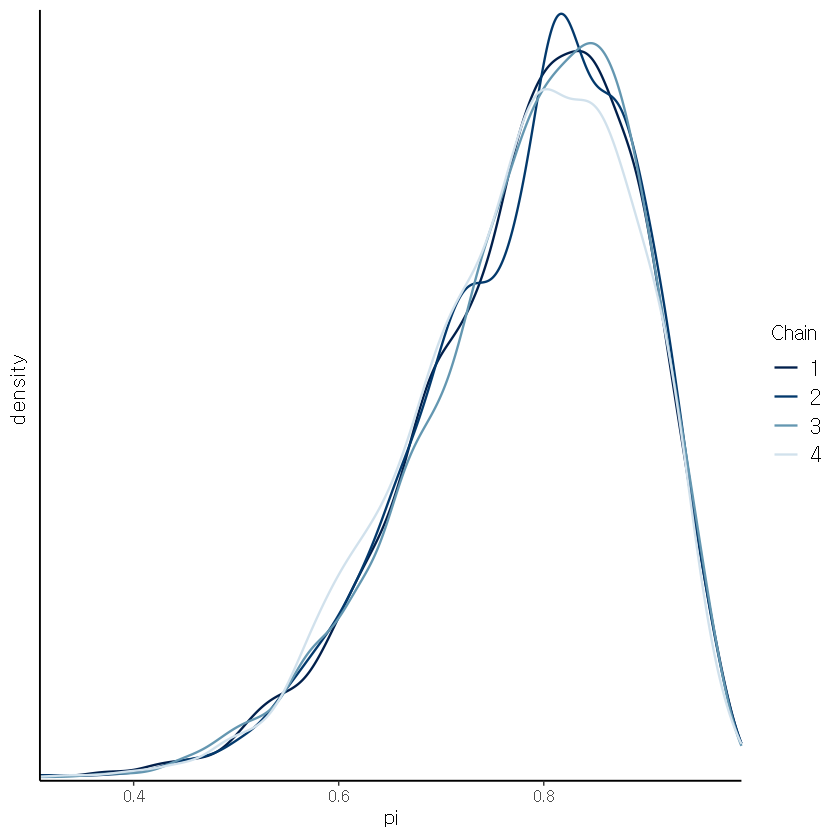

In [135]:
mcmc_dens_overlay(bb_sim, pars = "pi") + 
  ylab("density")

<br>

#### 체인의 길이를 감소시켰을 때
* **4개의 마르코프 체인이 각각 다른 사후분포 근사치를 도출 $\rightarrow$ 마르코프 체인의 길이는 적당히 길어야 함**

In [ ]:
bb_sim_short <- stan(model_code = bb_model, data = list(Y = 9), 
                     chains = 4, iter = 50*2, seed = 84735)

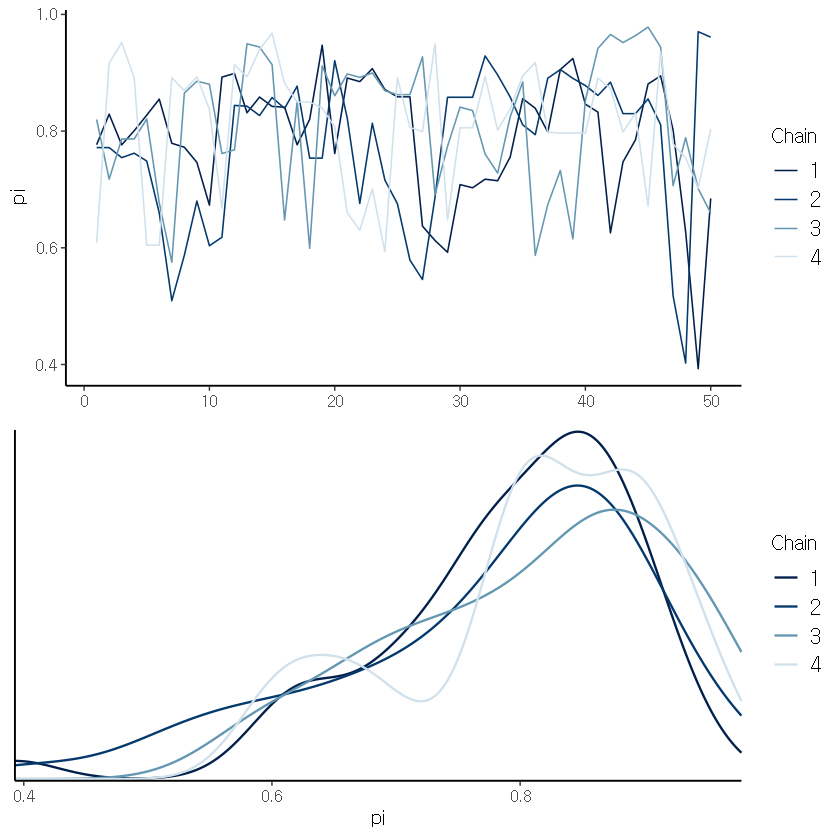

In [139]:
mcmc_trace(bb_sim_short, pars = "pi") -> p1

mcmc_dens_overlay(bb_sim_short, pars = "pi") -> p2

gridExtra::grid.arrange(p1, p2)

<br>

### (3) 유효표본크기 및 자기상관성

<br>

#### 유효표본크기
> $N$이 각 마르코프 체인의 길이일 때, 
>
> 유효표본크기 $N_{eff}$는 정밀한 사후분포 근사치를 생성하는 데 필요한 체인의 길이
>
> $N_{eff}$가 클수록 더 좋으며, 마르코프 체인의 길이가 적절하다는 근거

#### 유효표본크기 비율
> $$\frac{N_{eff}}{N}$$
> 대부분의 경우 비율은 1보다 작으며, 이는 마르코프 체인의 길이가 과도하게 길게 설정되었음을 의미
>
> 절대적인 기준값은 없지만, 경로분석과 함께 수반되어야 하며, 0.1보다 작다면 매우 좋지 않음을 의미
> 

<br>

#### `neff_ratio()` : 유효표본크기 비율 계산
- 마르코프 체인 길이의 적절한 값은 5000 $\times$ 4의 34.3%인 약 6900

In [141]:
neff_ratio(bb_sim, pars = c("pi"))

neff_ratio(bb_sim, pars = c("pi")) * 20000

[1] 0.3439479

[1] 6878.958

<br>

#### 자기상관성
> 체인의 $i$번째 값 $theta^{(i)}$와 주변 $m$개의 $\theta$값 간의 상관관계

<br>

- **강한 자기상관성은 좋지 않으며, 주로 작은 유효샘플크기 비율과 함께 발생 $\rightarrow$ 사후분포 근사치를 신뢰할 수 없다는 경고 신호**

<br>

#### `mcmc_acf()` : 마르코프 체인 경로에 대한 자기상관성 시각화

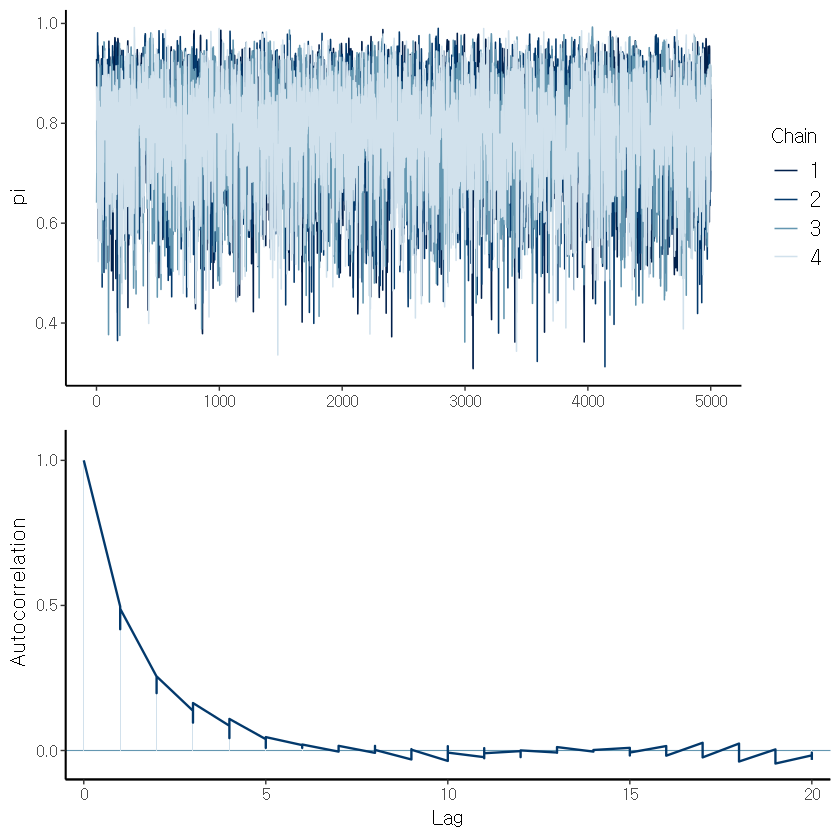

In [144]:
mcmc_trace(bb_sim, pars = "pi") -> p1
mcmc_acf(bb_sim, pars = "pi") -> p2

gridExtra::grid.arrange(p1, p2)

* 체인의 각 값은 본질적으로 상호 의존적이지만, 이러한 의존성이 몇 단계 떨어진 값에서는 상대적으로 약함

    $\rightarrow$ 적절한 $\theta$ 값 범위에서 빠르게 변동하여, 다양한 $\theta$값의 범위에 대해서 샘플 결과를 얻을 수 있다는 긍정적인 의미

<br>

#### 적절하지 않은 자기 상관형태
* **자기상관성이 천천히 감소한다는 것은 체인 값들 간의 의존성이 빠르게 사라지지 않음을 의미**
- **체인 값이 이전 값들과 매우 강하게 연결되어 있기 때문에, 이 체인은 $\theta$값 범위에 대해서 느리고 불균형하게 탐색이 진행**


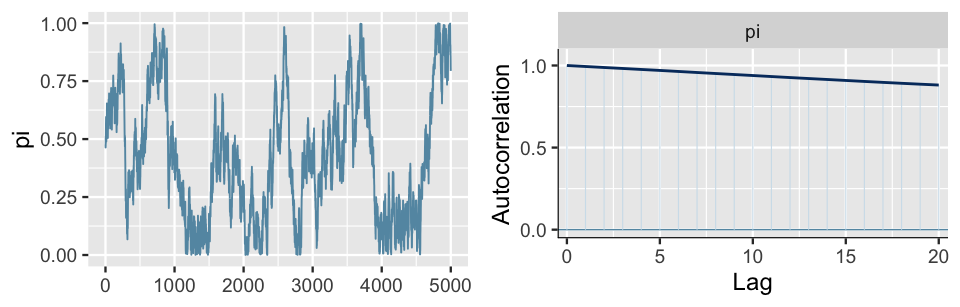

<br>

#### 그리드 탐색 속도
- **빠른 그리드 탐색 속도를 가지는 마르코프 체인은 체인의, 체인의 각 값 사이의 독립성을 만족하며, 각 값 사이의 자기상관성이 빠르게 감소지며, 유효표본크기 비율이 큼**


<br>

#### 자기상관성의 감소속도가 느리다면
1. **마르코프 체인의 길이를 증가**
2. **마르코프 체인의 두께를 얇게 설정**
    
    - **길이가 5000인 마르코프 체인 $\left\lbrace \pi^{(2)}, \pi^{(4)}, \pi^{(6)}, \ldots, \pi^{(5000)} \right\rbrace$에 대해서,**
    
        **$\left\lbrace \pi^{(10)}, \pi^{(20)}, \pi^{(30)}, \ldots, \pi^{(5000)} \right\rbrace$과 같이 10의 주기를 가진 체인의 값들만 추출 (그 사이의 값들은 제거)하여, 강한 자기상관성을 강제로 약화**
    
    - **활용할 수 있는 샘플의 수가 작아진다는 단점 존재**

In [ ]:
thinned_sim <- stan(model_code = bb_model, data = list(Y = 9), 
                    chains = 4, iter = 5000*2, seed = 84735, thin = 10)

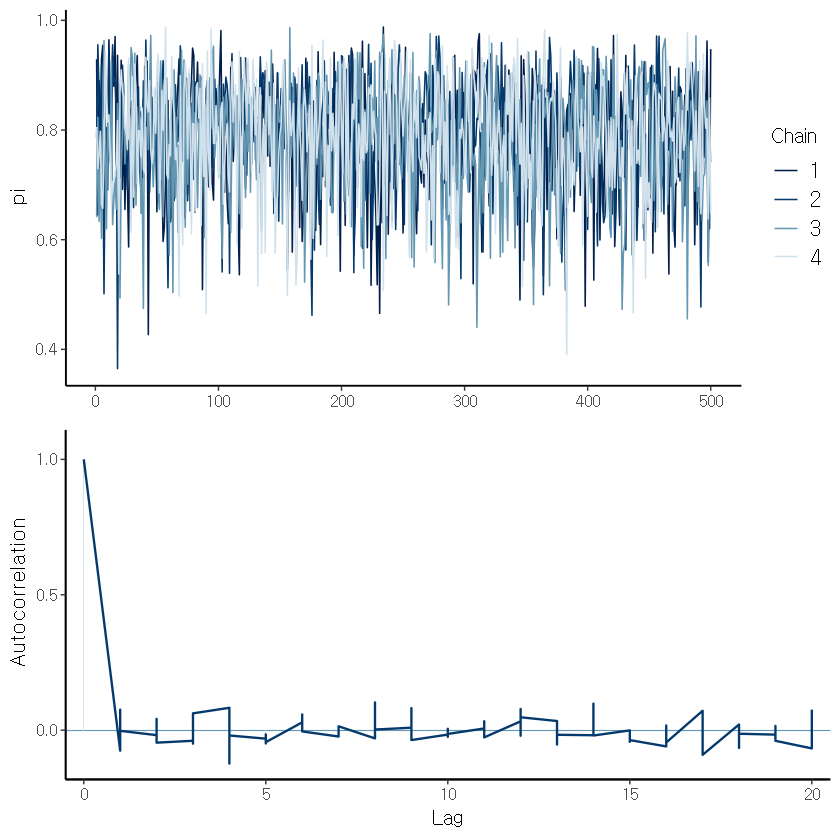

In [147]:
mcmc_trace(thinned_sim, pars = "pi") -> p1
mcmc_acf(thinned_sim, pars = "pi") -> p2

gridExtra::grid.arrange(p1, p2)

#### 마르코프 체인의 두께의 결정 
- **자기상관성이 감소하는 이점이, 체인 값의 손실보다 반드시 더 큰 것은 아님**

    **즉, 자기상관성이 더 강한 5000개의 마르코프 체인 값은, 자기 상관이 더 약한 500개의 체인 값보다 더 나은 사후분포 근사치를 생성할 수 있음**
    
    **(되도록 두께를 조정하지 않기 권장)**

<br>

## (4) R-hat 
> 매개변수 $\theta$에 대한 4개의 병렬적인 마르코프 체인에서, 
>
> $\text{Var}_\text{combined}$이 4개의 체인이 모두 결합된 상태에서 $\theta$의 변동성을 나타내고, 
>
> $\text{Var}_\text{within}$이 4개 체인별 일반적인 $\theta$ 변동을 의미할 때, 
> $$\text{R-hat} \approx \sqrt{\frac{\text{Var}_\text{combined}}{\text{Var}_\text{within}}}  .$$
>
> $\text{R-hat} \approx 1$일 때, 병렬적인 마르코프 체인 전체에 대한 안정성을 의미
>
> $\text{R-hat} > 1$일 때, 결합된 체인의 가변성이, 개별 체인 내 가변성을 초과하는 불안정성을 의미

> 보통 R-hat 비율이 1.05보다 크면 시뮬레이션의 안정성에 대한 위험 신호

<br>

#### `rhat()` : R-hat 계산

In [148]:
rhat(bb_sim, pars = "pi")

[1] 1.000425